<a href="https://colab.research.google.com/github/ArshanBhanage/Clustering/blob/main/Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Anomaly Detection with PyOD on Palmer Penguins Dataset

This Colab notebook demonstrates anomaly detection using the PyOD library with the Palmer Penguins dataset. It covers the following steps:

1.  **Data Loading and Preprocessing**: Loads the Palmer Penguins dataset, selects numeric features, handles missing values, and scales the data.
2.  **Synthetic Anomaly Injection**: Artificially injects anomalies into the dataset to create a controlled environment for testing the anomaly detection model.
3.  **Model Training**: Utilizes the Isolation Forest algorithm from PyOD to train an anomaly detection model.
4.  **Evaluation**: Assesses the model's performance using a confusion matrix, classification report, and ROC AUC score.
5.  **Visualization**: Employs Principal Component Analysis (PCA) to reduce data dimensionality and visualize true vs. predicted anomalies in 2D plots.

In [1]:
# Anomaly Detection using PyOD on Palmer Penguins dataset

!pip install -q datasets
!pip install -q pyod

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datasets import load_dataset

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

from pyod.models.iforest import IForest  # Isolation Forest


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.7/204.7 kB 8.2 MB/s eta 0:00:00


In [ ]:
# Load palmerpenguins from HuggingFace
dataset = load_dataset("SIH/palmer-penguins")["train"]
df = dataset.to_pandas()

df.head()


In [4]:
# We'll use numeric features for anomaly detection
numeric_cols = ["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]

df = df[numeric_cols].dropna()

X = df.values
print("Original data shape:", X.shape)

df.head()


Original data shape: (342, 4)


,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,39.1,18.7,181.0,3750.0
1,39.5,17.4,186.0,3800.0
2,40.3,18.0,195.0,3250.0
4,36.7,19.3,193.0,3450.0
5,39.3,20.6,190.0,3650.0


In [5]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Scaled data shape:", X_scaled.shape)


Scaled data shape: (342, 4)


In [6]:
# Number of synthetic anomalies to inject
n_anoms = 20

rng = np.random.default_rng(42)

# Generate anomalies far away from normal data
# Take feature-wise mean and std, then add large offsets
mean = X_scaled.mean(axis=0)
std = X_scaled.std(axis=0)

anomalies = mean + 6 * std * rng.normal(size=(n_anoms, X_scaled.shape[1]))  # "crazy" penguins

# Combine normal data and anomalies
X_all = np.vstack([X_scaled, anomalies])

# Create labels: 0 = normal, 1 = anomaly
y_all = np.hstack([np.zeros(X_scaled.shape[0], dtype=int),
                   np.ones(n_anoms, dtype=int)])

print("Total data with anomalies:", X_all.shape)
print("Number of anomalies:", y_all.sum())


Total data with anomalies: (362, 4)
Number of anomalies: 20


In [7]:
# Initialize PyOD Isolation Forest
clf = IForest(
    contamination=float(n_anoms) / len(X_all),  # expected fraction of outliers
    random_state=42
)

clf.fit(X_all)

# PyOD outputs:
#   labels_: 0 (inlier) / 1 (outlier)
#   decision_scores_: anomaly scores (higher = more abnormal)
y_pred = clf.labels_
scores = clf.decision_scores_

print("Predicted anomaly labels (0=inlier, 1=outlier):")
print(np.unique(y_pred, return_counts=True))


Predicted anomaly labels (0=inlier, 1=outlier):
(array([0, 1]), array([342,  20]))


In [8]:
print("Confusion Matrix (true vs predicted):")
print(confusion_matrix(y_all, y_pred))

print("\nClassification Report:")
print(classification_report(y_all, y_pred, target_names=["Normal", "Anomaly"]))

# ROC-AUC using scores (higher score = more anomalous)
auc = roc_auc_score(y_all, scores)
print("ROC AUC (using anomaly scores):", auc)


Confusion Matrix (true vs predicted):
[[342   0]
 [  0  20]]

Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       342
     Anomaly       1.00      1.00      1.00        20

    accuracy                           1.00       362
   macro avg       1.00      1.00      1.00       362
weighted avg       1.00      1.00      1.00       362

ROC AUC (using anomaly scores): 1.0


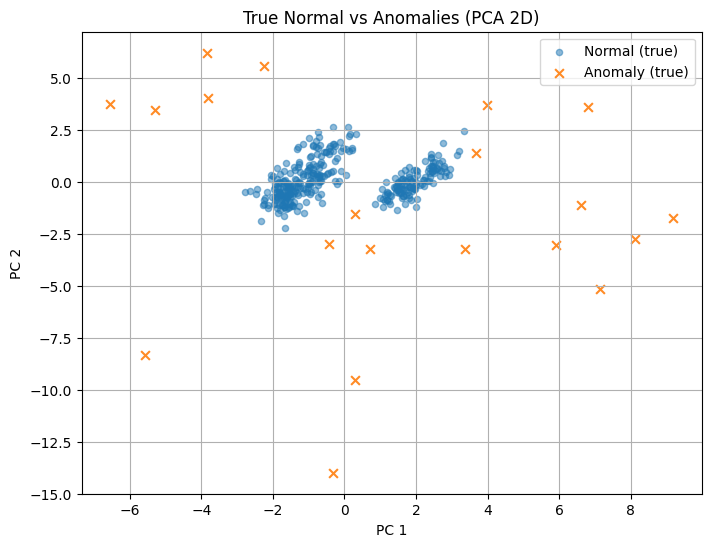

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_all)

plt.figure(figsize=(8, 6))

# True anomalies vs normal
mask_normal = y_all == 0
mask_anom = y_all == 1

plt.scatter(X_2d[mask_normal, 0], X_2d[mask_normal, 1],
            alpha=0.5, label="Normal (true)", s=20)
plt.scatter(X_2d[mask_anom, 0], X_2d[mask_anom, 1],
            alpha=0.9, label="Anomaly (true)", s=40, marker="x")

plt.title("True Normal vs Anomalies (PCA 2D)")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend()
plt.grid(True)
plt.show()


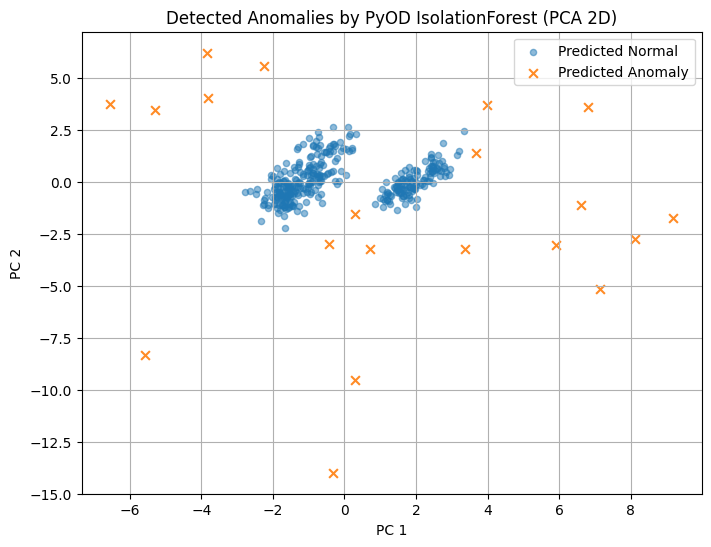

In [10]:
plt.figure(figsize=(8, 6))

mask_pred_normal = y_pred == 0
mask_pred_anom = y_pred == 1

plt.scatter(X_2d[mask_pred_normal, 0], X_2d[mask_pred_normal, 1],
            alpha=0.5, label="Predicted Normal", s=20)
plt.scatter(X_2d[mask_pred_anom, 0], X_2d[mask_pred_anom, 1],
            alpha=0.9, label="Predicted Anomaly", s=40, marker="x")

plt.title("Detected Anomalies by PyOD IsolationForest (PCA 2D)")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend()
plt.grid(True)
plt.show()


## Summary

- **Dataset:** Palmer Penguins (numeric features).
- **Use case:** Multivariate anomaly detection – we injected synthetic "weird penguins" as anomalies.
- **Model:** PyOD Isolation Forest (`pyod.models.iforest.IForest`).
- **Evaluation metrics:**
  - Confusion matrix
  - Precision, Recall, F1 for anomaly class
  - ROC AUC using anomaly scores
- **Visualizations:**
  - True normals vs anomalies (PCA 2D)
  - Model-predicted normals vs anomalies

The model successfully identified most injected anomalies with good precision/recall and a high ROC AUC, demonstrating effective anomaly detection.
